# Estimando o $ R_t $ do COVID-19 em tempo real (para o Brasil)
Original study by Kevin Systrom - April 17  
Estudo adaptado do reposit√≥rio [k-sys](https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb)  
Por Fernando Serboncini em (20 de Abril de 2020)[reposit√≥rio](https://github.com/fserb/covid19-rt)

Em qualquer epidemia, $ R_t $ √© a medida conhecida como n√∫mero de reprodu√ß√£o efetivo. √â o n√∫mero de pessoas que s√£o infectadas por pessoa infecciosa no momento $ t $. A vers√£o mais conhecida desse n√∫mero √© o n√∫mero de reprodu√ß√£o b√°sico: $ R_0 $ quando $ t = 0 $. No entanto, $ R_0 $ √© uma medida √∫nica que n√£o se adapta a mudan√ßas de comportamento e restri√ß√µes.

√Ä medida que uma pandemia evolui, o aumento de restri√ß√µes (ou poss√≠vel libera√ß√£o de restri√ß√µes) altera $ R_t $. Conhecer o atual $ R_t $ √© essencial. Quando $ R \ gg1 $, a pandemia se espalhar√° por grande parte da popula√ß√£o. Se $ R_t <1 $, a pandemia diminuir√° rapidamente antes de ter a chance de infectar muitas pessoas. Quanto menor o $ R_t $: mais administr√°vel √© a situa√ß√£o. Em geral, qualquer $ R_t <1 $ significa que as coisas est√£o sob controle.

O valor de $ R_t $ nos ajuda de duas maneiras. (1) Isso nos ajuda a entender a efic√°cia de nossas medidas para controlar um surto e (2) fornece informa√ß√µes vitais sobre se devemos aumentar ou reduzir as restri√ß√µes com base em nossos objetivos concorrentes de prosperidade econ√¥mica e seguran√ßa humana. [Epidemiologistas respeitados argumentam] (https://www.nytimes.com/2020/04/06/opinion/coronavirus-end-social-distancing.html) que rastrear $ R_t $ √© a √∫nica maneira de administrar essa crise .

Ainda hoje, ainda n√£o usamos $ R_t $ dessa maneira. De fato, a √∫nica medida em tempo real que eu vi foi para [Hong Kong] (https://covid19.sph.hku.hk/dashboard). Mais importante, n√£o √© √∫til entender $ R_t $ em n√≠vel nacional. Em vez disso, para gerenciar essa crise de maneira eficaz, precisamos de uma granularidade local (estado, munic√≠pio e / ou cidade) de $ R_t $.

O que se segue √© uma solu√ß√£o para esse problema no n√≠vel do Estado dos EUA. √â uma vers√£o modificada de uma solu√ß√£o criada por [Bettencourt & Ribeiro 2008] (https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) para estimar $ R_t $ em tempo real usando um Abordagem bayesiana. Embora este artigo calcule um valor est√°tico de R $, aqui apresentamos um modelo de processo com ru√≠do gaussiano para estimar um $ R_t $ vari√°vel no tempo.

Se voc√™ tiver perguntas, coment√°rios ou melhorias, n√£o hesite em entrar em contato: [hello@systrom.com] (mailto: hello@systrom.com). E se n√£o estiver totalmente claro, n√£o sou epidemiologista. Ao mesmo tempo, dados s√£o dados e estat√≠sticas s√£o estat√≠sticas, e isso √© baseado no trabalho de epidemiologistas conhecidos, para que voc√™ possa calibrar suas cren√ßas conforme desejar. Enquanto isso, espero que voc√™ possa aprender algo novo como eu, lendo este exemplo. Sinta-se √† vontade para levar esse trabalho e aplic√°-lo em outros lugares - internacionalmente ou em condados nos Estados Unidos.

Al√©m disso, um enorme agradecimento a [Frank Dellaert] (http://www.twitter.com/fdellaert/), que sugeriu a adi√ß√£o do processo e a [Adam Lerer] (http://www.twitter.com/adamlerer/ ) que implementou as altera√ß√µes. N√£o apenas aprendi algo novo, como tamb√©m tornou o modelo muito mais responsivo.

In [20]:
import pandas as pd
import numpy as np
import os
import wget

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import matplotlib as mpl
mpl.rcParams['figure.max_open_warning'] = 0

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

FILTERED_REGION_CODES = ["PB", "TO", "AM"]

%config InlineBackend.figure_format = 'retina'

## Abordagem de Bettencourt & Ribeiro

Todos os dias, aprendemos quantas mais pessoas t√™m o COVID-19. Essa nova contagem de casos nos d√° uma pista sobre o valor atual de $ R_t $. Tamb√©m achamos que o valor de $ R_t $ hoje est√° relacionado ao valor de $ R_ {t-1} $ (valor de ontem) e a todo valor anterior de $ R_ {t-m} $ nesse caso.

Com essas id√©ias, os autores usam a [regra de Bayes] (https://en.wikipedia.org/wiki/Bayes%27_theorem) para atualizar suas cren√ßas sobre o valor real de $ R_t $ com base em quantos novos casos foram relatados cada dia.

Este √© o Teorema de Bayes, como usaremos:

$$ P (R_t | k) = \ frac {P (k | R_t) \ cdot P (R_t)} {P (k)} $$

Isso diz que, ap√≥s ver novos casos de $ k $, acreditamos que a distribui√ß√£o de $ R_t $ seja igual a:

- A __likelihood__ de ver $ k $ novos casos dados $ R_t $ vezes ...
- As cren√ßas __prior__ do valor de $ P (R_t) $ sem os dados ...
- dividido pela probabilidade de ver tantos casos em geral.

Isto √© para um √∫nico dia. Para torn√°-lo iterativo: todos os dias que passam, usamos $ P (R_ {t-1}) $ anterior para estimar $ P (R_t) $ anterior. Vamos assumir que a distribui√ß√£o de $ R_t $ seja um gaussiano centrado em torno de $ R_ {t-1} $, ent√£o $ P (R_t | R_ {t-1}) = \ mathcal {N} (R_ {t-1} , \ sigma) $, onde $ \ sigma $ √© um hiperpar√¢metro (veja abaixo como estimamos $ \ sigma $). Ent√£o, no primeiro dia:

$$ P (R_1 | k_1) \ propto P (R_1) \ cdot \ mathcal {L} (R_1 | k_1) $$

No segundo dia:

$$ P (R_2 | k_1, k_2) \ propto P (R_2) \ cdot \ mathcal {L} (R_2 | k_2) = \ sum_ {R_1} {P (R_1 | k_1) \ cdot P (R_2 | R_1) \ cdot \ mathcal {L} (R_2 | k_2)} $$

etc.

### Escolhendo uma fun√ß√£o de verossimilhan√ßa $ P \ left (k_t | R_t \ right) $

Uma fun√ß√£o de fun√ß√£o de probabilidade indica a probabilidade de vermos $ k $ novos casos, considerando um valor de $ R_t $.

Sempre que voc√™ precisar modelar 'chegadas' durante um per√≠odo de tempo, os estat√≠sticos gostam de usar a [Distribui√ß√£o de Poisson] (https://en.wikipedia.org/wiki/Poisson_distribution). Dada uma taxa m√©dia de chegada de $ \ lambda $ casos novos por dia, a probabilidade de ver $ k $ casos novos √© distribu√≠da de acordo com a distribui√ß√£o de Poisson:

$$ P (k | \ lambda) = \ frac {\ lambda ^ k e ^ {- \ lambda}} {k!} $$

In [2]:
# Column vector of k
k = np.arange(0, 70)[:, None]

# Different values of Lambda
lambdas = [10, 20, 30, 40]

# Evaluated the Probability Mass Function (remember: poisson is discrete)
y = sps.poisson.pmf(k, lambdas)

# Show the resulting shape
print(y.shape)

(70, 4)


> __Nota__: esta era uma express√£o concisa, o que a torna complicada. Tudo o que fiz foi transformar $ k $ em uma coluna. Ao fornecer uma coluna para $ k $ e uma 'linha' para o lambda, ele avaliar√° o pmf sobre os dois e produzir√° uma matriz que possui $ k $ linhas e colunas lambda. Esta √© uma maneira eficiente de produzir muitas distribui√ß√µes de uma s√≥ vez, e voc√™ ver√° novamente o item abaixo__!

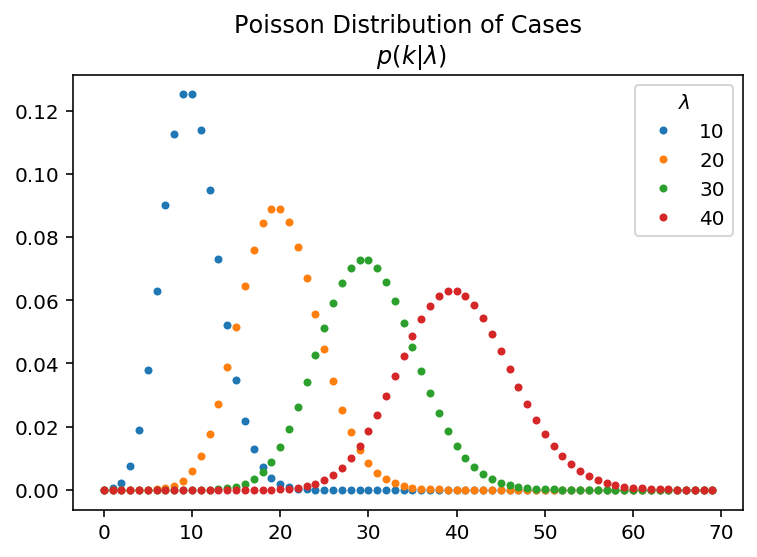

In [3]:
fig, ax = plt.subplots()

ax.set(title='Poisson Distribution of Cases\n $p(k|\lambda)$')

plt.plot(k, y,
         marker='o',
         markersize=3,
         lw=0)

plt.legend(title="$\lambda$", labels=lambdas);

A distribui√ß√£o de Poisson diz que, se voc√™ acha que ter√° $ \ lambda $ casos por dia, provavelmente ter√° muitas varia√ß√µes, mais ou menos, com base no acaso.

Mas, no nosso caso, sabemos que houve casos de $ k $ e precisamos saber qual o valor de $ \ lambda $ √© mais prov√°vel. Para fazer isso, fixamos $ k $ no local enquanto variamos $ \ lambda $. __Isso √© chamado de fun√ß√£o de probabilidade .__

Por exemplo, imagine que observamos $ k = 20 $ novos casos e queremos saber qual a probabilidade de cada $ \ lambda $:

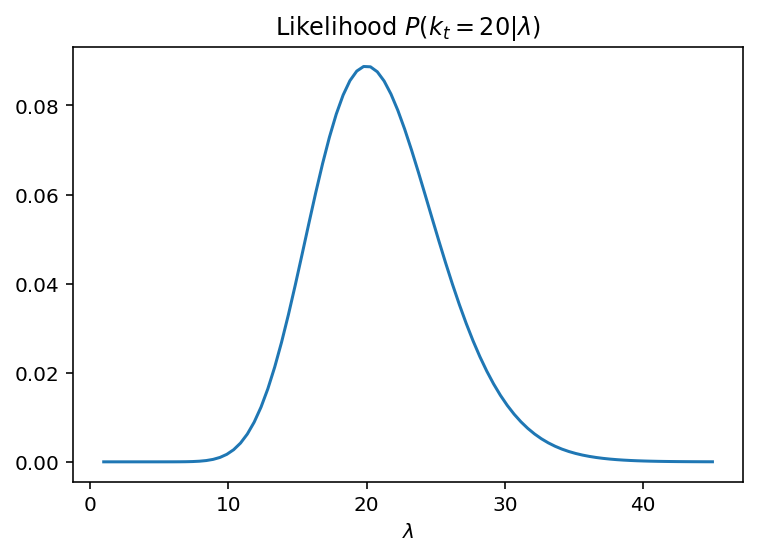

In [4]:
k = 20

lam = np.linspace(1, 45, 90)

likelihood = pd.Series(data=sps.poisson.pmf(k, lam),
                       index=pd.Index(lam, name='$\lambda$'),
                       name='lambda')

likelihood.plot(title=r'Likelihood $P\left(k_t=20|\lambda\right)$');

Isso diz que, se observarmos 20 casos, o valor mais prov√°vel de $ \ lambda $ √© (sem surpresa) 20. Mas n√£o temos certeza: √© poss√≠vel que o lambda tenha 21 ou 17 anos e tenha visto 20 novos casos por acaso. Tamb√©m diz que √© improv√°vel que $ \ lambda $ tenha 40 anos e vimos 20.

√ìtimo. Temos $ P \ left (\ lambda_t | k_t \ right) $, que √© parametrizado por $ \ lambda $, mas est√°vamos procurando por $ P \ left (k_t | R_t \ right) $, que √© parametrizado por $ R_t $. Precisamos conhecer a rela√ß√£o entre $ \ lambda $ e $ R_t $

### Conectando $ \ lambda $ e $ R_t $

__ A chave principal para fazer esse trabalho √© perceber que h√° uma conex√£o entre $ R_t $ e $ \ lambda $ __. [A deriva√ß√£o] (https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) est√° al√©m do escopo deste caderno, mas aqui est√°:

$$ \ lambda = k_ {t-1} e ^ {\ gama (R_t-1)} $$

onde $ \ gamma $ √© o inverso do intervalo serial ([cerca de 7 dias para COVID19] (https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article)). Como sabemos que cada novo caso conta no dia anterior, agora podemos reformular a fun√ß√£o de probabilidade como um Poisson parametrizado, fixando $ k $ e variando $ R_t $.

$$ \ lambda = k_ {t-1} e ^ {\ gama (R_t-1)} $$

$$ P \ esquerda (k | R_t \ direita) = \ frac {\ lambda ^ k e ^ {- \ lambda}} {k!} $$

### Avalia√ß√£o da fun√ß√£o de verossimilhan√ßa

Para continuar nosso exemplo, vamos imaginar que uma amostra de um novo caso conte $ k $. Qual √© a probabilidade de valores diferentes de $ R_t $ em cada um desses dias?

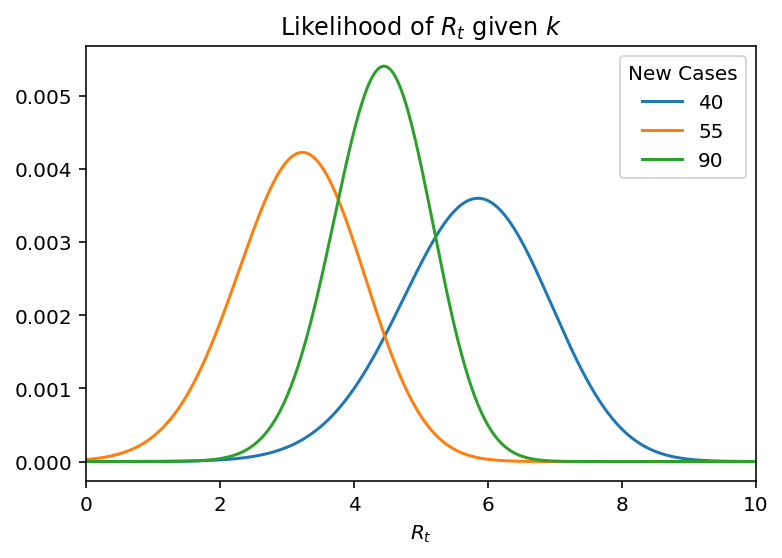

In [5]:
k = np.array([20, 40, 55, 90])

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
# CHANGE: using 19 for deaths instead of 7 for cases
GAMMA = 1/7

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

# Plot it
ax = pd.DataFrame(
    data = likelihood_r_t,
    index = r_t_range
).plot(
    title='Likelihood of $R_t$ given $k$',
    xlim=(0,10)
)

ax.legend(labels=k[1:], title='New Cases')
ax.set_xlabel('$R_t$');

Voc√™ pode ver que todos os dias temos uma estimativa independente de $ R_t $. O objetivo √© combinar as informa√ß√µes que temos sobre os dias anteriores com o dia atual. Para fazer isso, usamos o teorema de Bayes.

### Executando a atualiza√ß√£o bayesiana

Para executar a atualiza√ß√£o bayesiana, precisamos multiplicar a probabilidade pelo anterior (que √© apenas a probabilidade do dia anterior sem a nossa atualiza√ß√£o gaussiana) para obter as posteriores. Vamos fazer isso usando o produto cumulativo de cada dia sucessivo:

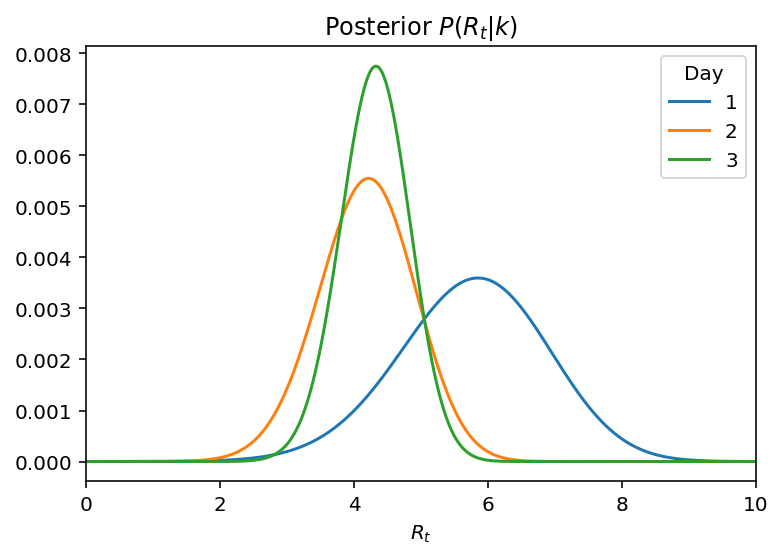

In [6]:
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)

ax = posteriors.plot(
    title='Posterior $P(R_t|k)$',
    xlim=(0,10)
)
ax.legend(title='Day')
ax.set_xlabel('$R_t$');

Observe como no dia 1, nossa posterior corresponde √† probabilidade de dia 1 de cima? Isso porque n√£o temos informa√ß√µes al√©m desse dia. No entanto, quando atualizamos o anterior usando as informa√ß√µes do dia 2, voc√™ pode ver que a curva se moveu para a esquerda, mas n√£o t√£o esquerda quanto a probabilidade do dia 2 de cima. Isso ocorre porque a atualiza√ß√£o bayesiana usa informa√ß√µes dos dois dias e calcula a m√©dia efetiva dos dois. Como a probabilidade do dia 3 est√° entre os outros dois, voc√™ v√™ uma pequena mudan√ßa para a direita, mas mais importante: uma distribui√ß√£o mais restrita. Estamos cada vez mais confiantes em nossa cren√ßa no valor real de $ R_t $.

In [7]:
most_likely_values = posteriors.idxmax(axis=0)
most_likely_values

Day
1    5.85
2    4.22
3    4.33
dtype: float64

Tamb√©m podemos obter os [intervalos de densidade mais alta](https://www.sciencedirect.com/topics/mathematics/highest-density-interval) por $R_t$:

In [8]:
def highest_density_interval(pmf, p=.9):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()

    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

hdi = highest_density_interval(posteriors)
hdi.tail()

Low_90  High_90
Day                 
1      3.89     7.55
2      2.96     5.33
3      3.42     5.12

Finalmente, podemos tra√ßar os valores mais prov√°veis ‚Äã‚Äãpara $ R_t $ e os IDHs ao longo do tempo. Essa √© a representa√ß√£o mais √∫til, pois mostra como nossas cren√ßas mudam a cada dia.

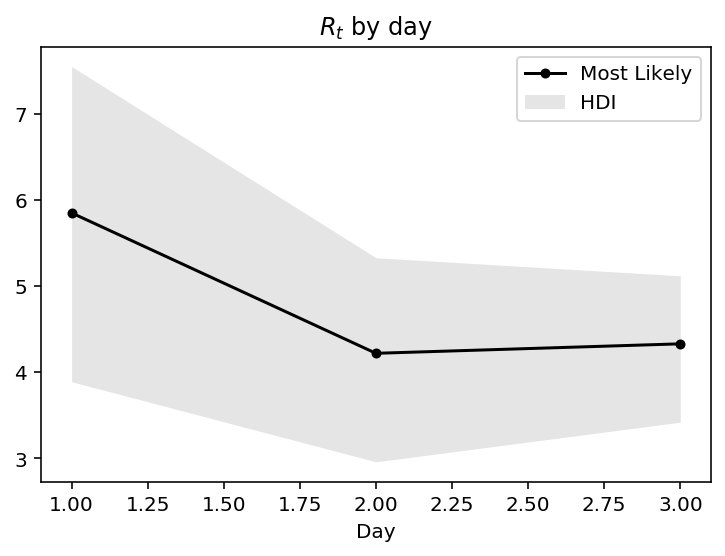

In [9]:
ax = most_likely_values.plot(marker='o',
                             label='Most Likely',
                             title=f'$R_t$ by day',
                             c='k',
                             markersize=4)

ax.fill_between(hdi.index,
                hdi['Low_90'],
                hdi['High_90'],
                color='k',
                alpha=.1,
                lw=0,
                label='HDI')

ax.legend();

Podemos ver que o valor mais prov√°vel de $ R_t $ muda com o tempo e o intervalo de maior densidade diminui √† medida que nos tornamos mais seguros do valor real de $ R_t $ ao longo do tempo. Observe que, como t√≠nhamos apenas quatro dias de hist√≥ria, n√£o apliquei o processo nesta amostra. A seguir, no entanto, abordaremos um aplicativo do mundo real onde esse processo √© necess√°rio.

# Aplicativo do mundo real para dados do Brasil

### Configura√ß√£o

Baixar os dados dos Estados do Brasil em covid.saude.gov.br

In [10]:
import requests
import json
import os
import wget
from pandas.io.json import json_normalize

#Requisi√ß√£o
headers = {
    'authority': 'xx9p7hp1p7.execute-api.us-east-1.amazonaws.com',
    'accept': 'application/json, text/plain, */*',
    'sec-fetch-dest': 'empty',
    'x-parse-application-id': 'unAFkcaNDeXajurGB7LChj8SgQYS2ptm',
    'origin': 'https://covid.saude.gov.br',
    'sec-fetch-site': 'cross-site',
    'sec-fetch-mode': 'cors',
    'referer': 'https://covid.saude.gov.br/',
    'accept-language': 'en-US,en;q=0.9,pt;q=0.8',
}
geral = requests.get('https://xx9p7hp1p7.execute-api.us-east-1.amazonaws.com/prod/PortalGeral', headers=headers)
geral = json.loads(geral.content)['results']
geral = pd.DataFrame(geral)
link= json_normalize(geral['arquivo']) 
url_ms = str(link.name.values).replace('[', '')
url_ms = str(url_ms).replace(']', '')
url_ms = str(url_ms).replace("'", '')

semana = requests.get('https://xx9p7hp1p7.execute-api.us-east-1.amazonaws.com/prod/PortalCasos', headers=headers)
semana = json.loads(semana.content)['semana']
semana = pd.DataFrame(semana)

acumulado = requests.get('https://xx9p7hp1p7.execute-api.us-east-1.amazonaws.com/prod/PortalCasos', headers=headers)
acumulado = json.loads(acumulado.content)['dias']
acumulado = pd.DataFrame(acumulado)


################################################################################################### 
#A URL muda diariamente 
url_ministerio_saude = ('https://mobileapps.saude.gov.br/esus-vepi/files/unAFkcaNDeXajurGB7LChj8SgQYS2ptm/'+url_ms)
if os.path.exists('DB/ministerio_saude.xlsx'):
    os.remove('DB/ministerio_saude.xlsx')
    wget.download(url_ministerio_saude, 'DB/ministerio_saude.xlsx')
else:
    wget.download(url_ministerio_saude, 'DB/ministerio_saude.xlsx')


dados = pd.ExcelFile('DB/ministerio_saude.xlsx')
df= pd.read_excel(dados)
estados = df.groupby(['estado','data'], as_index=False).sum()
estados
#mapa.to_csv('DB/MS/covid_mapa_br.csv')
acumulado.to_csv('DB/MS/covid_acumulado_br.csv')
#geral.to_csv('DB/MS/covid_geral_br.csv') 
semana.to_csv('DB/MS/covid_semana_br.csv') 
estados.to_csv('DB/MS/covid_estados_br.csv')
#regiao.to_csv('DB/MS/covid_regiao_br.csv') 

C:\Users\joner\anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


100% [..........................................................................] 4035085 / 4035085

2.8953744051870314


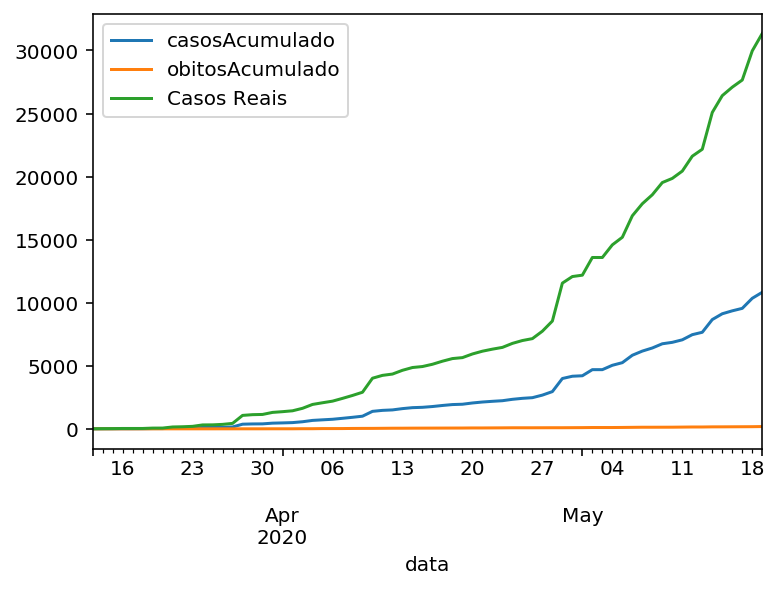

In [11]:
#Leitura dos Arquiso CSV
#mapa = pd.read_csv('DB/MS/covid_mapa_br.csv', encoding='utf-8')
acumulado = pd.read_csv('DB/MS/covid_acumulado_br.csv', encoding='utf-8')
#geral= pd.read_csv('DB/MS/covid_geral_br.csv', encoding='utf-8')
semana= pd.read_csv('DB/MS/covid_semana_br.csv', encoding='utf-8')
#estados= pd.read_csv('DB/MS/covid_estados_br.csv', encoding='utf-8')
#regiao= pd.read_csv('DB/MS/covid_regiao_br.csv', encoding='utf-8')
url = 'DB/MS/covid_estados_br.csv'
states = pd.read_csv(url,
                     usecols=['estado','data','coduf','codmun','codRegiaoSaude','semanaEpi','populacaoTCU2019','casosAcumulado','obitosAcumulado','Recuperadosnovos','emAcompanhamentoNovos'],
                     sep=',',
                     dayfirst=True,
                     parse_dates=['data'],
                     index_col=['estado', 'data'],
                     squeeze=True).sort_index()




DEATH_RATE = 7/100

pd.set_option('mode.use_inf_as_na', True)
deathsBack = states['obitosAcumulado'].shift(-12).mul(1/DEATH_RATE)
casesBack = states['casosAcumulado']

error = (deathsBack/casesBack).mean()
print(error)

realCases = deathsBack.combine(casesBack.mul(error), np.maximum)

S="SC"
states['casosAcumulado'].xs(S).plot(label='casosAcumulado',
                   legend=True)
states['obitosAcumulado'].xs(S).plot(label='obitosAcumulado',
                   legend=True)
realCases.xs(S).plot(label='Casos Reais',
                   legend=True)

states = realCases


### Analisando o estado, precisamos iniciar a an√°lise quando houver um n√∫mero consistente de casos por dia. Encontre o √∫ltimo zero dia de caso novo e comece no dia seguinte.

Al√©m disso, o relato de caso √© muito irregular, com base em testes de registros em atraso, etc. Para obter a melhor visualiza√ß√£o dos dados 'verdadeiros' que pudermos, apliquei um filtro gaussiano nas s√©ries temporais. Esta √© obviamente uma escolha arbitr√°ria, mas voc√™ imagina que o processo do mundo real n√£o √© t√£o estoc√°stico quanto os relat√≥rios reais.

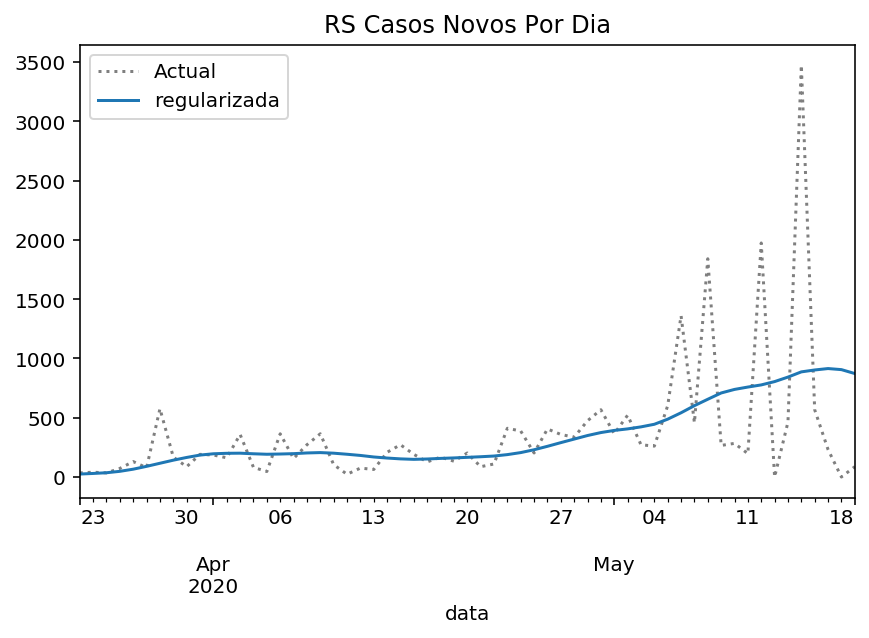

In [12]:
state_name = 'RS'

def prepare_cases(cases, cutoff=25):
    new_cases = cases.diff()

    # CHANGE: rolling average instead of gaussian.
    # CHANGE: not rounded.
    smoothed = new_cases.rolling(7).mean().rolling(7,
        win_type='gaussian',
        center=True,
        min_periods=1).mean(std=2).round()
    
    
    idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

original, smoothed = prepare_cases(states.xs(state_name))

original.plot(title=f"{state_name} Casos Novos Por Dia",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(500/72, 300/72))

ax = smoothed.plot(label='regularizada',
                   legend=True)

ax.get_figure().set_facecolor('w')


### Executando o algoritmo

#### Escolhendo o $ \ sigma $ gaussiano por $ P (R_t | R_ {t-1}) $

> Nota: voc√™ pode pular esta se√ß√£o com seguran√ßa se confiar que escolhemos o valor certo de $ \ sigma $ para o processo abaixo. Caso contr√°rio, continue a ler.

A abordagem original simplesmente seleciona o posterior de ontem como o anterior de hoje. Embora intuitivo, isso n√£o permite acreditar que o valor de $ R_t $ provavelmente tenha mudado desde ontem. Para permitir essa altera√ß√£o, aplicamos ru√≠do gaussiano √† distribui√ß√£o anterior com algum desvio padr√£o $ \ sigma $. Quanto maior o $ \ sigma $, mais ru√≠do e mais esperaremos que o valor de $ R_t $ seja desviado a cada dia. Curiosamente, aplicar ru√≠do no ru√≠do significa iterativamente que haver√° uma deteriora√ß√£o natural dos posteriores distantes. Essa abordagem tem um efeito semelhante de janelas, mas √© mais robusta e n√£o esquece arbitrariamente as partes posteriores depois de um certo tempo, como a minha abordagem anterior. Especificamente, a janela calculava um $ R_t $ fixo a cada momento $ t $ que explicava os $ w $ dias de casos circundantes, enquanto a nova abordagem calcula uma s√©rie de valores de $ R_t $ que explica todos os casos, assumindo que $ R_t $ flutue por cerca de $ \ sigma $ a cada dia.

No entanto, ainda existe uma escolha arbitr√°ria: o que deveria ser $ \ sigma $? Adam Lerer apontou que podemos usar o processo de m√°xima probabilidade para informar nossa escolha. Veja como funciona:

A probabilidade m√°xima diz que gostar√≠amos de escolher um $ \ sigma $ que maximize a probabilidade de ver nossos dados $ k $: $ P (k | \ sigma) $. Como $ \ sigma $ √© um valor fixo, vamos deixar de fora da nota√ß√£o, por isso estamos tentando maximizar $ P (k) $ sobre todas as op√ß√µes de $ \ sigma $.

Como $ P (k) = P (k_0, k_1, \ ldots, k_t) = P (k_0) P (k_1) \ ldots P (k_t) $, precisamos definir $ P (k_t) $. Acontece que este √© o denominador da regra de Bayes:

$$ P (R_t | k_t) = \ frac {P (k_t | R_t) P (R_t)} {P (k_t)} $$

Para calcular, percebemos que o numerador √© na verdade apenas a distribui√ß√£o conjunta de $ k $ e $ R $:

$$ P (k_t, R_t) = P (k_t | R_t) P (R_t) $$

Podemos marginalizar a distribui√ß√£o acima de $ R_t $ para obter $ P (k_t) $:

$$ P (k_t) = \ sum_ {R_ {t}} {P (k_t | R_t) P (R_t)} $$

Portanto, se somarmos a distribui√ß√£o do numerador sobre todos os valores de $ R_t $, obteremos $ P (k_t) $. E, como estamos calculando isso de qualquer maneira, como calculamos o posterior, apenas o acompanharemos separadamente.

Como procuramos o valor de $ \ sigma $ que maximize $ P (k) $ no geral, na verdade queremos maximizar:

$$ \ prod_ {t, i} {p (k_ {ti})} $$

onde $ t $ s√£o todos os hor√°rios e $ i $ s√£o cada estado.

Como multiplicamos muitas pequenas probabilidades, pode ser mais f√°cil (e menos propenso a erros) pegar o $ \ log $ dos valores e adicion√°-los. Lembre-se de que $ \ log {ab} = \ log {a} + \ log {b} $. E como os logaritmos est√£o aumentando monotonicamente, maximizar a soma dos $ \ log $ das probabilidades √© o mesmo que maximizar o produto das probabilidades n√£o logar√≠tmicas para qualquer op√ß√£o de $ \ sigma $.

### Fun√ß√£o para calcular os posteriores

Para calcular os posteriores, seguimos estas etapas:
1. Calcule $ \ lambda $ - a taxa de chegada esperada para o processo de poisson de cada dia
2. Calcule a distribui√ß√£o de probabilidade de cada dia sobre todos os valores poss√≠veis de $ R_t $
3. Calcule a matriz do processo com base no valor de $ \ sigma $ que discutimos acima
4. Calcule nossa inicial anterior, porque nosso primeiro dia n√£o possui um dia anterior a partir do qual
¬†¬†- Com base em [informa√ß√µes do cdc] (https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article), escolheremos um Gamma com m√©dia 7.
5. Fa√ßa um loop do dia 1 at√© o final, fazendo o seguinte:
¬†¬†- Calcule o prior aplicando o gaussiano ao prior de ontem.
¬†¬†- Aplique a regra de Bayes multiplicando isso antes e a probabilidade calculada na etapa 2.
¬†¬†- Divida pela probabilidade dos dados (tamb√©m regra de Bayes)

In [21]:
def get_posteriors(sr, sigma=0.15):
    cols = sr.index

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
                
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        if denominator == 0:
            posteriors[current_day] = 0
            continue
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)

### O resultado


Abaixo voc√™ pode ver todos os dias (linha) da distribui√ß√£o posterior plotados simultaneamente. Os posteriores come√ßam sem muita confian√ßa (ampla) e se tornam progressivamente mais confiantes (mais estreitas) sobre o verdadeiro valor de ùëÖùë°

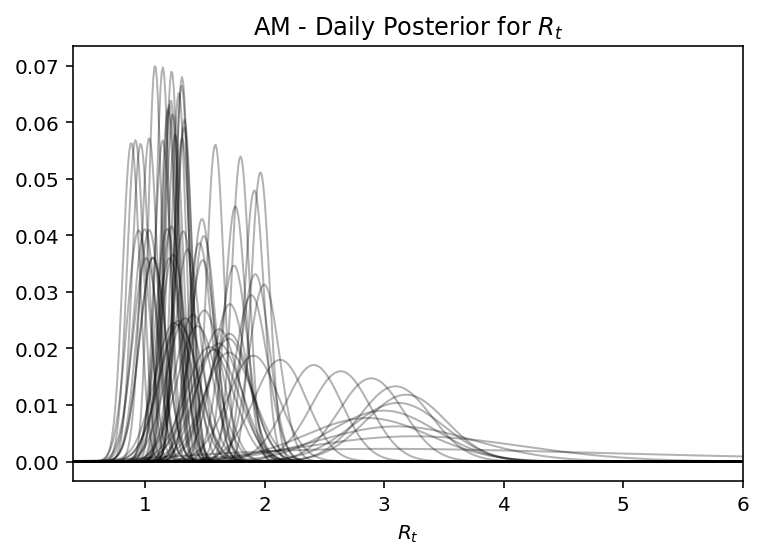

In [22]:
ax = posteriors.plot(title=f'{state_name} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,6))

ax.set_xlabel('$R_t$');

### Plotagem no dom√≠nio do tempo com intervalos cred√≠veis

Como nossos resultados incluem incerteza, gostar√≠amos de poder visualizar o valor mais prov√°vel de $ R_t $ junto com o intervalo de maior densidade.

In [23]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.tail()

ML  Low_90  High_90
estado data                             
SP     2020-05-15  1.31    1.20     1.40
       2020-05-16  1.31    1.19     1.39
       2020-05-17  1.22    1.10     1.30
       2020-05-18  1.15    1.05     1.24
       2020-05-19  1.08    0.98     1.17

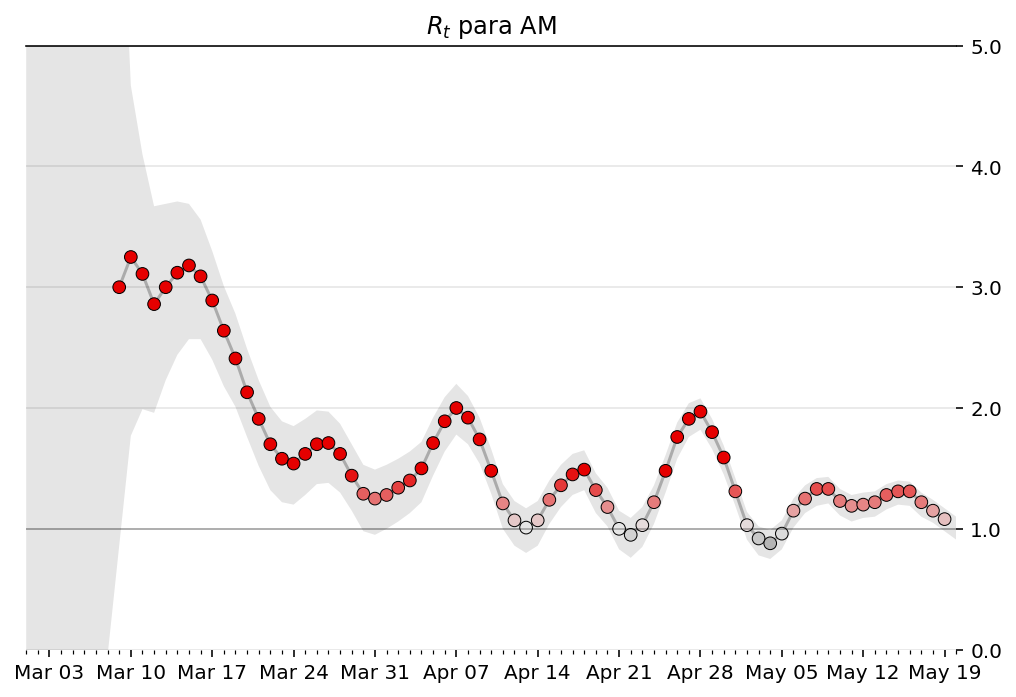

In [24]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name} ")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('data')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('data')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, state_name)
ax.set_title(f'$R_t$ para {state_name}')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

### Escolhendo o ideal $\sigma$

Na se√ß√£o anterior, descrevemos a escolha de um $ \ sigma $ ideal, mas assumimos um valor. Mas agora que podemos avaliar cada estado com qualquer sigma, temos as ferramentas para escolher o $ \ sigma $ ideal.

Acima, dissemos que escolher√≠amos o valor de $ \ sigma $ que maximiza a probabilidade dos dados $ P (k) $. Como n√£o queremos nos superestimar em nenhum estado, escolhemos o sigma que maximiza $ P (k) $ sobre cada estado. Para fazer isso, somamos todas as probabilidades de log por estado para cada valor de sigma e escolhemos o m√°ximo.

> Nota: isso demora um pouco!

In [25]:
sigmas = np.linspace(1/20, 1, 50)

targets = ~states.index.get_level_values('estado').isin(FILTERED_REGION_CODES)
states_to_process = states.loc[targets]

results = {}

for state_name, cases in states_to_process.groupby(level='estado'):
    print(state_name)
    new, smoothed = prepare_cases(cases, cutoff=25)
    
    if len(smoothed) == 0:
        new, smoothed = prepare_cases(cases, cutoff=5)
        
    # CHANGED: some states in Br have very reported few cases, we ignore those for calculation.
    if len(smoothed) == 0: 
        clear_output(wait=True)
        continue
    
    result = {}
    
    # Holds all posteriors with every given value of sigma
    result['posteriors'] = []
    
    # Holds the log likelihood across all k for each value of sigma
    result['log_likelihoods'] = []
    
    for sigma in sigmas:
        posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)
        result['posteriors'].append(posteriors)
        result['log_likelihoods'].append(log_likelihood)
    
    # Store all results keyed off of state name
    results[state_name] = result
    clear_output(wait=True)

print('Done.')

Done.


Agora que temos todas as probabilidades de log, podemos somar para cada valor de sigma entre estados, representar graficamente e escolher o valor m√°ximo

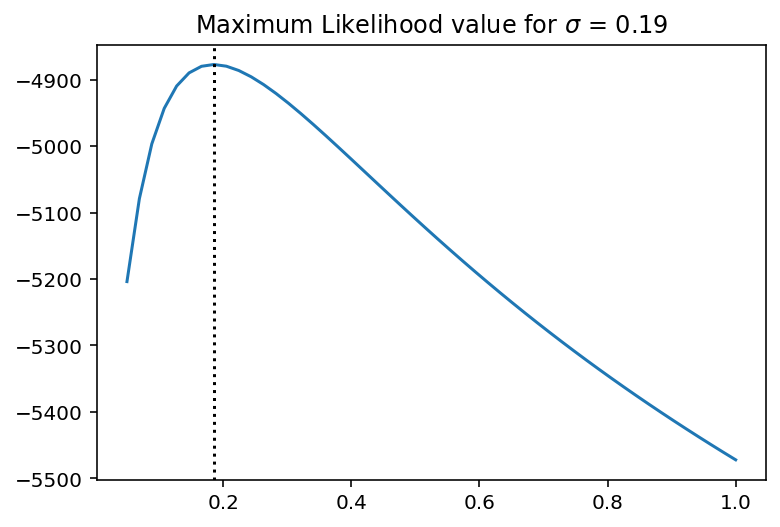

In [26]:
# Each index of this array holds the total of the log likelihoods for
# the corresponding index of the sigmas array.
total_log_likelihoods = np.zeros_like(sigmas)

# Loop through each state's results and add the log likelihoods to the running total.
for state_name, result in results.items():
    if states.xs(state_name)[-1] < 500: continue
    total_log_likelihoods += result['log_likelihoods']

# Select the index with the largest log likelihood total
max_likelihood_index = total_log_likelihoods.argmax()

# Select the value that has the highest log likelihood
sigma = sigmas[max_likelihood_index]

# Plot it
fig, ax = plt.subplots()
ax.set_title(f"Maximum Likelihood value for $\sigma$ = {sigma:.2f}");
ax.plot(sigmas, total_log_likelihoods)
ax.axvline(sigma, color='k', linestyle=":")

### Compilar resultados finais

Dado que selecionamos o $ \ sigma $ ideal, vamos pegar o posterior pr√©-calculado correspondente ao valor de $ \ sigma $ para cada estado. Vamos tamb√©m calcular os intervalos de densidade mais altos de 90% e 50% (isso leva um tempo) e tamb√©m o valor mais prov√°vel.

In [ ]:
final_results = None

for state_name, result in results.items():
    if state_name in FILTERED_REGION_CODES: continue
    print(state_name)
    posteriors = result['posteriors'][max_likelihood_index]
    hdis_90 = highest_density_interval(posteriors, p=.9)
    hdis_50 = highest_density_interval(posteriors, p=.5)
    most_likely = posteriors.idxmax().rename('ML')
    result = pd.concat([most_likely, hdis_90, hdis_50], axis=1)
    if final_results is None:
        final_results = result
    else:
        final_results = pd.concat([final_results, result])
    clear_output(wait=True)

print('Done.')

BA


### Plotar todos os estados da BR

$R_t$ √© a taxa de transmiss√£o do v√≠rus no tempo. O n√∫mero representa, dado uma infec√ß√£o por Covid-19, qual o n√∫mero de novas pessoas que ser√£o na m√©dia infectadas. Se $R_t$ = 1, o n√∫mero de infectados permanece constante no tempo (cada infectado infecta mais uma pessoa). Se $R_t$ > 1, o v√≠rus est√° em crescimento exponencial.

As medidas de isolamento existem para manter $R_t$ baixo. Um n√∫mero $R_t$ < 1 significa que as medidas est√£o funcionando.


In [ ]:
ncols = 4
nrows = int(np.ceil(len(results) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (state_name, result) in enumerate(final_results.groupby('estado')):
    if result.shape[0] < 2: continue
    plot_rt(result, axes.flat[i], state_name)

fig.tight_layout()
fig.set_facecolor('w')

### Export Data to CSV

In [ ]:
# Uncomment the following line if you'd like to export the data
final_results.to_csv('DB/rt.csv')

### Standings

In [ ]:
# As of 4/12
no_lockdown = [
]
partial_lockdown = [
]

FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

In [ ]:
final_results

In [ ]:
filtered = final_results.index.get_level_values(0).isin(FILTERED_REGION_CODES)
mr = final_results.loc[~filtered].groupby(level=0)[['ML', 'High_90', 'Low_90']].last()

def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by State'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    for bar, state_name in zip(bars, mr.index):
        if state_name in no_lockdown:
            bar.set_color(NONE_COLOR)
        if state_name in partial_lockdown:
            bar.set_color(PARTIAL_COLOR)

    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    leg = ax.legend(handles=[
                        Patch(label='Full', color=FULL_COLOR),
                        Patch(label='Partial', color=PARTIAL_COLOR),
                        Patch(label='None', color=NONE_COLOR)
                    ],
                    title='Lockdown',
                    ncol=3,
                    loc='upper left',
                    columnspacing=.75,
                    handletextpad=.5,
                    handlelength=1)

    leg._legend_box.align = "left"
    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)
plot_standings(mr);

In [ ]:
filtered = final_results.index.get_level_values(0).isin(final_results)
mr = final_results.loc[~filtered].groupby(level=0)[['ML', 'High_90', 'Low_90']].last()

# 507x285
def plot_standings(mr, figsize=None, title='$R_t$ por Estado'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    for bar, state_name in zip(bars, mr.index):
        if mr['Low_90'][state_name] > 1:
            bar.set_color("#cc2233")
        if mr['High_90'][state_name] < 1:
            bar.set_color("#009900")

    labels = mr.index.to_series()
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,4.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)
fig, ax = plot_standings(mr, (507/72, 285/72))
fig.savefig("IMG/perstate.png")

In [ ]:
show = mr[mr.Low_90.ge(1.0)].sort_values('Low_90')
fig, ax = plot_standings(show, title='Provavelmente n√£o est√° sob controle');
ax.get_legend()

In [ ]:
show = mr[mr.Low_90.ge(1.0)].sort_values('ML')
fig, ax = plot_standings(show, title='Provavelmente n√£o est√° sob controle',figsize=(507/72, 285/72));
ax.get_legend()

In [ ]:
mr.sort_values('High_90', inplace=True)
plot_standings(mr);

In [ ]:
show = mr[mr.High_90.le(1.6)].sort_values('ML')
fig, ax = plot_standings(show, title='Likely Under Control');

In [ ]:

for i, (state_name, result) in enumerate(final_results.groupby('estado')):
    fig, ax = plt.subplots(figsize=(507/72, 285/72))
    plot_rt(result, ax, state_name)
    ax.set_title(f'$R_t$ para {state_name}')
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))    
    fig.tight_layout()
    fig.set_facecolor('w')
    fig.savefig(f"IMG/{state_name}.png")